# HW 13

## 13.1
Write a basic Spark implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input.
Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), 
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).
[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability d,
one of the hyperlinks in the current page. This probability is represented by a so-called
‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and “teleports” to that page]

In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.

In [235]:
import findspark
import time
import matplotlib.pyplot as plt
findspark.init()

In [220]:
%matplotlib inline

In [107]:
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local').setAppName('master')
sc = SparkContext(conf = conf)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=master, master=local) created by __init__ at <ipython-input-2-f493162bd33f>:3 

In [108]:
!cat ./PageRank-test.txt

B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}


In [109]:
raw_data = sc.textFile("./PageRank-test.txt")

#process data

def processLine(line):
    splits = line.strip().split('\t')
    return [splits[0], eval(splits[1])]
data = raw_data.map(processLine).cache()

In [110]:
#count nodes
def mapCount(entry):
    yield (str(entry[0]), 1)
    for key, value in entry[1].items():
        yield (key, 1)
        
nodecount = data.flatMap(mapCount).reduceByKey(lambda x, y: 1).count()
broadcast_nodecount = sc.broadcast(nodecount)

In [111]:
print "There are " + str(broadcast_nodecount.value) + " listed nodes."

There are 11 listed nodes.


In [120]:
#prep data
#nodes that don't have edges need to be better represented

def prep_map(entry):
    nodeID = entry[0]
    edges = entry[1]
    for edge, weight in edges.items():
        yield (str(edge.strip()), {})
    yield (str(nodeID), edges)
    
def prep_reduce(x, y):
    edges = {}
    for key, value in x.items():
        edges[key] = value
    for key, value in y.items():
        edges[key] = value
    return edges

total_pr = sc.accumulator(0.0)

def init_entry(entry):
    total_pr.add(1.0 / broadcast_nodecount.value)
    return (entry[0], [entry[1], 1.0 / broadcast_nodecount.value])

prepped_data = data.flatMap(prep_map).reduceByKey(prep_reduce).map(init_entry).cache()

print prepped_data.collect()

print total_pr.value


[('A', [{}, 0.09090909090909091]), ('C', [{'B': 1}, 0.09090909090909091]), ('B', [{'C': 1}, 0.09090909090909091]), ('E', [{'B': 1, 'D': 1, 'F': 1}, 0.09090909090909091]), ('D', [{'A': 1, 'B': 1}, 0.09090909090909091]), ('G', [{'B': 1, 'E': 1}, 0.09090909090909091]), ('F', [{'B': 1, 'E': 1}, 0.09090909090909091]), ('I', [{'B': 1, 'E': 1}, 0.09090909090909091]), ('H', [{'B': 1, 'E': 1}, 0.09090909090909091]), ('K', [{'E': 1}, 0.09090909090909091]), ('J', [{'E': 1}, 0.09090909090909091])]
1.0


In [116]:
accum_dangling_mass = sc.accumulator(0.0)
accum_mass_moved = sc.accumulator(0)

broadcast_damping_factor = sc.broadcast(.15)
broadcast_dangling_mass = sc.broadcast(0.0)

In [183]:
def phaseOneMapper(entry):
    label = entry[0]
    edges = entry[1][0]
    pr = entry[1][1]

    if len(edges) == 0:
        accum_dangling_mass.add(pr)
    else:
        forwarding_pr = pr / len(edges)
        for edge, weight in edges.items():
            yield (edge, [{}, forwarding_pr])
    yield (label, [edges, 0.0])

def phaseOneReducer(x, y):
    edges = {}
    for edge, weight in x[0].items():
        edges[edge] = weight
    for edge, weight in y[0].items():
        edges[edge] = weight
    return [edges, x[1] + y[1]]

def finalize(entry, dangling_mass):
    label = str(entry[0])
    edges = entry[1][0]
    pr = entry[1][1]

    pr_prime = broadcast_damping_factor.value * (1.0 / broadcast_nodecount.value) + \
    (1 - broadcast_damping_factor.value) * (dangling_mass / broadcast_nodecount.value + pr)

    return (label, [edges, pr_prime])

    

In [139]:
#initial testing
accum_dangling_mass = sc.accumulator(0.0)

broadcast_damping_factor = sc.broadcast(.15)

print prepped_data.flatMap(phaseOneMapper).collect()

accum_dangling_mass = sc.accumulator(0.0)


print prepped_data.flatMap(phaseOneMapper).map(lambda x: x[1][1]).reduce(lambda x, y: x + y) + \
    accum_dangling_mass.value


#                 .reduceByKey(phaseOneReducer)\
#                 .map(lambda x: finalize(x, accum_dangling_mass.value))\
#                 .collect()


[('A', [{}, 0.0]), ('B', [{}, 0.09090909090909091]), ('C', [{'B': 1}, 0.0]), ('C', [{}, 0.09090909090909091]), ('B', [{'C': 1}, 0.0]), ('B', [{}, 0.030303030303030304]), ('D', [{}, 0.030303030303030304]), ('F', [{}, 0.030303030303030304]), ('E', [{'B': 1, 'D': 1, 'F': 1}, 0.0]), ('A', [{}, 0.045454545454545456]), ('B', [{}, 0.045454545454545456]), ('D', [{'A': 1, 'B': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('G', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('F', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('I', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('H', [{'B': 1, 'E': 1}, 0.0]), ('E', [{}, 0.09090909090909091]), ('K', [{'E': 1}, 0.0]), ('E', [{}, 0.09090909090909091]), ('J', [{'E': 1}, 0.0])]
1.0


In [144]:
#phase two testing


broadcast_damping_factor = sc.broadcast(.15)

accum_dangling_mass = sc.accumulator(0.0)

print prepped_data.flatMap(phaseOneMapper).collect()

accum_dangling_mass = sc.accumulator(0.0)


prepped_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer).collect()
#                 .map(lambda x: finalize(x, accum_dangling_mass.value))\
#                 .collect()

accum_dangling_mass = sc.accumulator(0.0)
prepped_data.flatMap(phaseOneMapper)\
    .reduceByKey(phaseOneReducer)\
    .map(lambda x: x[1][1])\
    .reduce(lambda x, y: x + y)\
    + accum_dangling_mass.value


[('A', [{}, 0.0]), ('B', [{}, 0.09090909090909091]), ('C', [{'B': 1}, 0.0]), ('C', [{}, 0.09090909090909091]), ('B', [{'C': 1}, 0.0]), ('B', [{}, 0.030303030303030304]), ('D', [{}, 0.030303030303030304]), ('F', [{}, 0.030303030303030304]), ('E', [{'B': 1, 'D': 1, 'F': 1}, 0.0]), ('A', [{}, 0.045454545454545456]), ('B', [{}, 0.045454545454545456]), ('D', [{'A': 1, 'B': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('G', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('F', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('I', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('H', [{'B': 1, 'E': 1}, 0.0]), ('E', [{}, 0.09090909090909091]), ('K', [{'E': 1}, 0.0]), ('E', [{}, 0.09090909090909091]), ('J', [{'E': 1}, 0.0])]


1.0

In [185]:
#full pipeline testing


broadcast_damping_factor = sc.broadcast(.15)

accum_dangling_mass = sc.accumulator(0.0)

print prepped_data.flatMap(phaseOneMapper).collect()

accum_dangling_mass = sc.accumulator(0.0)

! rm -rf ./intermediate/
prepped_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer).saveAsTextFile("./intermediate")
!cat intermediate/part-00000

danging_mass = accum_dangling_mass.value

intermediate_data = sc.textFile("./intermediate/part-00000").map(deserialize)\
                .map(lambda x: finalize(x, danging_mass))
    
print intermediate_data.collect()
    
total_pr =  intermediate_data.map(lambda x: x[1][1]).reduce(lambda x, y: x + y)
        


print total_pr

[('A', [{}, 0.0]), ('B', [{}, 0.09090909090909091]), ('C', [{'B': 1}, 0.0]), ('C', [{}, 0.09090909090909091]), ('B', [{'C': 1}, 0.0]), ('B', [{}, 0.030303030303030304]), ('D', [{}, 0.030303030303030304]), ('F', [{}, 0.030303030303030304]), ('E', [{'B': 1, 'D': 1, 'F': 1}, 0.0]), ('A', [{}, 0.045454545454545456]), ('B', [{}, 0.045454545454545456]), ('D', [{'A': 1, 'B': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('G', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('F', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('I', [{'B': 1, 'E': 1}, 0.0]), ('B', [{}, 0.045454545454545456]), ('E', [{}, 0.045454545454545456]), ('H', [{'B': 1, 'E': 1}, 0.0]), ('E', [{}, 0.09090909090909091]), ('K', [{'E': 1}, 0.0]), ('E', [{}, 0.09090909090909091]), ('J', [{'E': 1}, 0.0])]
('A', [{}, 0.045454545454545456])
('C', [{'B': 1}, 0.09090909090909091])
('B', [{'C': 1}, 0.34

In [203]:
# turn into a loop


broadcast_damping_factor = sc.broadcast(.15)

accum_dangling_mass = sc.accumulator(0.0)

print prepped_data.flatMap(phaseOneMapper).collect()

accum_dangling_mass = sc.accumulator(0.0)

prepped_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer).cache()
prepped_data.take(1)

dangling_mass = accum_dangling_mass.value

print "Initial dangling mass: " + str(dangling_mass)

intermediate_data = prepped_data.map(lambda x: finalize(x, dangling_mass)).cache()
intermediate_data.take(1)
    
for i in range(30):
    
    print "Iteration: " + str(i)
    accum_dangling_mass = sc.accumulator(0.0)

    intermediate_data = intermediate_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer)
    intermediate_data.cache()
    intermediate_data.take(1)
    
    
    dangling_mass = accum_dangling_mass.value
    print "Total dangling mass: " + str(dangling_mass)

    intermediate_data = intermediate_data.map(lambda x: finalize(x, dangling_mass))
    intermediate_data.cache()
    intermediate_data.take(1)
    
    
print "\n\n\n"
print "Final results:\n"
    

    
total_pr =  intermediate_data.map(lambda x: x[1][1]).reduce(lambda x, y: x + y)
print total_pr

[('A', [{}, 0.0, 0.0]), ('B', [{}, 0.09090909090909091, 0.0]), ('C', [{'B': 1}, 0.0, 0.0]), ('C', [{}, 0.09090909090909091, 0.0]), ('B', [{'C': 1}, 0.0, 0.0]), ('B', [{}, 0.030303030303030304, 0.0]), ('D', [{}, 0.030303030303030304, 0.0]), ('F', [{}, 0.030303030303030304, 0.0]), ('E', [{'B': 1, 'D': 1, 'F': 1}, 0.0, 0.0]), ('A', [{}, 0.045454545454545456, 0.0]), ('B', [{}, 0.045454545454545456, 0.0]), ('D', [{'A': 1, 'B': 1}, 0.0, 0.0]), ('B', [{}, 0.045454545454545456, 0.0]), ('E', [{}, 0.045454545454545456, 0.0]), ('G', [{'B': 1, 'E': 1}, 0.0, 0.0]), ('B', [{}, 0.045454545454545456, 0.0]), ('E', [{}, 0.045454545454545456, 0.0]), ('F', [{'B': 1, 'E': 1}, 0.0, 0.0]), ('B', [{}, 0.045454545454545456, 0.0]), ('E', [{}, 0.045454545454545456, 0.0]), ('I', [{'B': 1, 'E': 1}, 0.0, 0.0]), ('B', [{}, 0.045454545454545456, 0.0]), ('E', [{}, 0.045454545454545456, 0.0]), ('H', [{'B': 1, 'E': 1}, 0.0, 0.0]), ('E', [{}, 0.09090909090909091, 0.0]), ('K', [{'E': 1}, 0.0, 0.0]), ('E', [{}, 0.090909090

In [204]:
intermediate_data.collect()

[('A', [{}, 0.03278149400279799, 0.0]),
 ('C', [{'B': 1}, 0.34371441659524926, 0.0]),
 ('B', [{'C': 1}, 0.3835968127677896, 0.0]),
 ('E', [{'B': 1, 'D': 1, 'F': 1}, 0.08088569474079228, 0.0]),
 ('D', [{'A': 1, 'B': 1}, 0.03908709308143792, 0.0]),
 ('G', [{'B': 1, 'E': 1}, 0.01616947914609888, 0.0]),
 ('F', [{'B': 1, 'E': 1}, 0.03908709308143792, 0.0]),
 ('I', [{'B': 1, 'E': 1}, 0.01616947914609888, 0.0]),
 ('H', [{'B': 1, 'E': 1}, 0.01616947914609888, 0.0]),
 ('K', [{'E': 1}, 0.01616947914609888, 0.0]),
 ('J', [{'E': 1}, 0.01616947914609888, 0.0])]

In [233]:
# adding convergence checking

def mapCount(entry):
    yield (str(entry[0]), 1)
    for key, value in entry[1].items():
        yield (key, 1)
        

def processLine(line):
    splits = line.strip().split('\t')
    return [splits[0], eval(splits[1])]

def prep_map(entry):
    nodeID = entry[0]
    edges = entry[1]
    for edge, weight in edges.items():
        yield (str(edge.strip()), {})
    yield (str(nodeID), edges)
    
def prep_reduce(x, y):
    edges = {}
    for key, value in x.items():
        edges[key] = value
    for key, value in y.items():
        edges[key] = value
    return edges

accum_total_pr = sc.accumulator(0.0)

def init_entry(entry):
    accum_total_pr.add(1.0 / broadcast_nodecount.value)
    return (entry[0], [entry[1], 1.0 / broadcast_nodecount.value, 0.0]) #the 0.0 is the previous pr 

accum_dangling_mass = sc.accumulator(0.0)
accum_moved_mass = sc.accumulator(0.0)


def phaseOneMapper(entry):
    label = entry[0]
    edges = entry[1][0]
    pr = entry[1][1]
    previous = pr

    if len(edges) == 0:
        accum_dangling_mass.add(pr)
    else:
        forwarding_pr = pr / len(edges)
        for edge, weight in edges.items():
            yield (edge, [{}, forwarding_pr, 0.0])
    yield (label, [edges, 0.0, pr])

def phaseOneReducer(x, y):
    edges = {}
    for edge, weight in x[0].items():
        edges[edge] = weight
    for edge, weight in y[0].items():
        edges[edge] = weight
    return [edges, x[1] + y[1], x[2] + y[2]]

def finalize(entry, dangling_mass):
    label = str(entry[0])
    edges = entry[1][0]
    pr = entry[1][1]
    previous = entry[1][2]
    pr_prime = broadcast_damping_factor.value * (1.0 / broadcast_nodecount.value) + \
    (1 - broadcast_damping_factor.value) * (dangling_mass / broadcast_nodecount.value + pr)
    accum_moved_mass.add(((pr_prime - previous)**2)**.5)
    return (label, [edges, pr_prime])

    

There are 11 nodes in the dataset
(0.12020111084)

Data prepped
(0.126798868179)

Initial dangling mass: 0.0
Dangling mass distributed
(0.1082239151)

Iteration 1 runtime: 0.195286989212
Iteration 2 runtime: 0.195838212967
Iteration 3 runtime: 0.19593000412
Iteration 4 runtime: 0.23746919632
Iteration 5 runtime: 0.322229862213
Iteration 6 runtime: 0.201852798462
Iteration 7 runtime: 0.198018074036
Iteration 8 runtime: 0.19601392746
Iteration 9 runtime: 0.199529886246
Iteration 10 runtime: 0.196079969406
Iteration 11 runtime: 0.195308923721
Iteration 12 runtime: 0.196223974228
Iteration 13 runtime: 0.236058950424
Iteration 14 runtime: 0.195821046829
Iteration 15 runtime: 0.204102993011
Iteration 16 runtime: 0.192075967789
Iteration 17 runtime: 0.200066804886
Iteration 18 runtime: 0.191590070724
Iteration 19 runtime: 0.204566001892
Iteration 20 runtime: 0.195238113403
Iteration 21 runtime: 0.207958936691
Iteration 22 runtime: 0.195813894272
Iteration 23 runtime: 0.203940868378
Iteration 

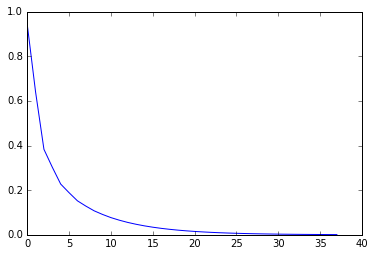

In [239]:
verbose = False

data = sc.textFile("./PageRank-test.txt").map(processLine)

overall_start_time = time.time()

start_time = time.time()
nodecount = data.flatMap(mapCount).reduceByKey(lambda x, y: 1).count()
nodecount_time = time.time() - start_time
broadcast_nodecount = sc.broadcast(nodecount)

print "There are " + str(broadcast_nodecount.value) + " nodes in the dataset"
print "(" + str(nodecount_time) + ")\n"

prepped_data = data.flatMap(prep_map).reduceByKey(prep_reduce).map(init_entry)

broadcast_damping_factor = sc.broadcast(.15)

accum_dangling_mass = sc.accumulator(0.0)
accum_moved_mass = sc.accumulator(1.0)
accum_total_pr = sc.accumulator(0.0)

start_time = time.time()
prepped_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer).cache()
prepped_data.take(1)
prep_time = time.time() - start_time
print "Data prepped"
print "(" + str(prep_time) + ")\n"

dangling_mass = accum_dangling_mass.value

print "Initial dangling mass: " + str(dangling_mass)

start_time = time.time()
intermediate_data = prepped_data.map(lambda x: finalize(x, dangling_mass)).cache()
intermediate_data.take(1)
distribute_time = time.time() - start_time
print "Dangling mass distributed"
print "(" + str(distribute_time) + ")\n"


deltas = []
i = 0
while accum_moved_mass.value >= .001 and i < 40:
    i += 1
    if verbose:
        print "Iteration: " + str(i)
    accum_dangling_mass = sc.accumulator(0.0)
    accum_moved_mass = sc.accumulator(0.0)
    
    iteration_start_time = time.time()

    intermediate_data = intermediate_data.flatMap(phaseOneMapper).reduceByKey(phaseOneReducer)
    intermediate_data.cache()
    intermediate_data.take(1)
    
    
    dangling_mass = accum_dangling_mass.value
    if verbose:
        print "Total dangling mass: " + str(dangling_mass)

    intermediate_data = intermediate_data.map(lambda x: finalize(x, dangling_mass))
    intermediate_data.cache()
    intermediate_data.take(1)
    if verbose:
        print "Moved mass: " + str(accum_moved_mass.value) 
        print "Total pr: " + str(intermediate_data.map(lambda x: x[1][1]).reduce(lambda x, y: x + y)) + "\n"
    deltas.append(accum_moved_mass.value)
    iteration_runtime = time.time() - iteration_start_time
    print "Iteration " + str(i) + " runtime: " + str(iteration_runtime) 
    
overall_runtime = time.time() - overall_start_time
    
print "\n\n\n"
print "Results:\n"
print "Iterations: " + str(i)
print "Runtime: " + str(overall_runtime)
print "Moved mass on final iteration: " + str(accum_moved_mass.value)
plt.plot(deltas)




In [ ]:
print "Total pr :" + str(intermediate_data.map(lambda x: x[1][1))

#### Results:
.1: 10

.01: 24

.001: 38